In [178]:
# importing required libraries
import numpy as np
import pandas as pd

import datetime as dt
import yfinance as yf
import pandas_datareader.data as web
import cpi
import wbdata
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import matplotlib.pyplot as plt


# cpi.update()


In [179]:
# customize seed for different stocks
np.random.seed(42)

# list of all potential stocks 
ticker_list = ['AAPL','AXP', 'BAC', 'C', 'CSCO', 'GS', 'IBM', 'INTC', 'JPM', 'MSFT', 'NVDA', 'CRM', 'QCOM', 'NOW', 'ORCL', 'AVGO', 'GDDY',
               'WIX', 'TSM', 'TSLA', 'SNOW', 'HUBS', 'DOCU', 'MS']

# selecting 15 random stocks
stock_list = np.random.choice(ticker_list,15,replace=False)
stock_list = list(np.sort(stock_list))
print(f'These are the fifteen stocks assigned to you: {" ".join(stock_list)}')



These are the fifteen stocks assigned to you: AAPL AVGO AXP BAC C CRM CSCO GDDY GS HUBS JPM MSFT NOW QCOM TSM


In [180]:
# defining start and end date
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2024, 12, 31)

# getting returns of the stocks
# calculates returns using adjusted close price
# ensures that we have returns of only those dates where all companies have available information
returns = yf.download(stock_list, start-pd.offsets.BDay(1), end+pd.offsets.BDay(1), auto_adjust=False)['Adj Close'].pct_change().dropna()

# gets all returns Close, high, low, open, volume
#returns = yf.download(stock_list, start, end)

# S&P 500
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(period="25y")
sp500_data['SP500'] = sp500_data['Close'].pct_change()
sp500_data = sp500_data.drop(columns=["Open", "High", "Low", "Close", "Volume", "Dividends", "Stock Splits"])

sp500_data.index = sp500_data.index.strftime('%m-%d-%Y')
sp500_data.index = pd.to_datetime(sp500_data.index)
# sp500_mon = sp500_data.resample(rule = 'ME').apply(lambda x: x.add(1).prod().sub(1))



[*********************100%***********************]  15 of 15 completed


In [181]:
# Find finding monthly returns
returns = pd.merge(returns, sp500_data, left_index = True, right_index = True )

returns_mon = returns.resample(rule = 'ME').apply(lambda x: x.add(1).prod().sub(1))

In [182]:
# Standard deviation for 2018, May SP500 
sp500_stdev = returns.loc[(returns.index.year == 2018) & (returns.index.month == 5)]['SP500'].std()
print(f"The standard deviation for SP500 in May of 2018 is {sp500_stdev}")

# Calculating STDEV for each month
monthly_std = returns.groupby(by=[returns.index.month, returns.index.year]).std()
monthly_std.index = pd.to_datetime(monthly_std.index.map(lambda x: f"{x[1]}-{x[0]}"), format="%Y-%m")
monthly_std.sort_index(inplace=True)
monthly_std.index = returns_mon.index

# Double check 
monthly_std

The standard deviation for SP500 in May of 2018 is 0.006550294321030805


,AAPL,AVGO,AXP,BAC,C,CRM,CSCO,GDDY,GS,HUBS,JPM,MSFT,NOW,QCOM,TSM,SP500
Date,,,,,,,,,,,,,,,,
2015-04-30,0.012397,0.016856,0.012424,0.008424,0.008354,0.028444,0.010488,0.070891,0.009064,0.013713,0.009037,0.025081,0.033490,0.011213,0.013286,0.005342
2015-05-31,0.013944,0.026372,0.007434,0.009589,0.009210,0.018310,0.008173,0.021200,0.007721,0.046019,0.008157,0.012823,0.010829,0.010724,0.008015,0.006810
2015-06-30,0.007134,0.015256,0.009610,0.012553,0.011136,0.013844,0.009101,0.023059,0.010503,0.016141,0.010172,0.009569,0.019477,0.010455,0.014186,0.007012
2015-07-31,0.015632,0.022670,0.010292,0.015152,0.015019,0.013050,0.008952,0.019378,0.009260,0.015368,0.010288,0.012318,0.017386,0.013122,0.016081,0.007372
2015-08-31,0.027477,0.033035,0.019951,0.022048,0.021412,0.025278,0.020600,0.031955,0.018642,0.029138,0.020382,0.023279,0.022192,0.019290,0.018067,0.016831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.014390,0.035466,0.020996,0.016534,0.022454,0.017542,0.020368,0.020209,0.018847,0.018766,0.014808,0.012256,0.015843,0.031815,0.027338,0.012262
2024-09-30,0.014810,0.038684,0.016769,0.012883,0.018849,0.015801,0.009361,0.019505,0.019290,0.015217,0.015982,0.011563,0.017725,0.024127,0.031525,0.008719
2024-10-31,0.013200,0.022745,0.014756,0.014381,0.020357,0.013960,0.011385,0.012157,0.012744,0.018603,0.014478,0.015659,0.017850,0.022151,0.027663,0.006936


In [183]:
# Finding other features we care about 
# Finding risk free-rate
rf = web.DataReader('F-F_Research_Data_Factors','famafrench', start, end)[0][['RF']].div(100)
rf.index = rf.index.to_timestamp(how='end').normalize()

# CPI data from FRED
cpi = web.DataReader('CPIAUCSL', 'fred', start, end)

# Calculate monthly inflation rates as percentage change
inflation_rate = cpi.pct_change().dropna()
inflation_rate.index = inflation_rate.index.to_period('M').to_timestamp(how='end').normalize()
inflation_rate.columns = ['Inflation Rate']

# Rolling Average
rolling_avg = returns.rolling(window=30).mean()
rolling_avg.columns = [name+"_ROLL_AVG" for name in rolling_avg.columns]
rolling_monthly = rolling_avg.resample('M').last()

/var/folders/hn/ds6pkb3n5j16s47f26mbf8x40000gn/T/ipykernel_4609/2669399645.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  rf = web.DataReader('F-F_Research_Data_Factors','famafrench', start, end)[0][['RF']].div(100)
/var/folders/hn/ds6pkb3n5j16s47f26mbf8x40000gn/T/ipykernel_4609/2669399645.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  rf = web.DataReader('F-F_Research_Data_Factors','famafrench', start, end)[0][['RF']].div(100)
/var/folders/hn/ds6pkb3n5j16s47f26mbf8x40000gn/T/ipykernel_4609/2669399645.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rolling_monthly = rolling_avg.resample('M').last()


In [184]:
# Creating the final df 
result = pd.concat([returns_mon, monthly_std], axis=1, keys=['RETURN', 'STDEV'])
result.columns = result.columns.get_level_values(1) + '_' + result.columns.get_level_values(0).astype(str)


result = pd.merge(result, rf, how='left', left_index=True, right_index=True)
result = pd.merge(result, inflation_rate, how = 'left', left_index=True, right_index=True) 
result = pd.merge(result, rolling_monthly, how = 'left', left_index=True, right_index=True)

# Removing first two rows because rolling average has errors
result = result.iloc[2:]


# MLP 
LSTM 

In [ ]:
def test_train_split(stock): 
    df = pd.concat([result.filter(like = stock),result[['SP500_RETURN','SP500_STDEV', 'RF', 'Inflation Rate']]], axis=1)
    df.sort_index(inplace=True)

    # # Including past historical distorts the result 
    # aapl = aapl.loc[(aapl.index.year >= 2022)]

    # shift target variable 
    df[f"Next_{stock}_RETURN"] = df[f"{stock}_RETURN"].shift(-1)


    # NaN in last row because of the shift 
    df.dropna(inplace=True)


    # Defining target and features 
    features = [col for col in df.columns if col not in [f"Next_{stock}_RETURN"]]
    target = f"Next_{stock}_RETURN"

    X = df[features]
    y = df[target]

    # Normalize and split the data 
    # scaler = StandardScaler()
    scaler = MinMaxScaler() 

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # reshaping because lstm needs 3d input 
    X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    return df, X_train, X_test, y_train, y_test






def lstm(X_train, X_test, y_train, y_test): 
    model = Sequential([
    LSTM(50, return_sequences=True),  # , input_shape=(X_train.shape[1], X_train.shape[2])), 
    LSTM(50),
    Dense(25, activation='relu'), #try something else 
    Dense(1)
])

    model.compile(optimizer="adam", loss="mse")

    model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test))
    
    next_month_pred = model.predict(X_test[-1].reshape(1, 1, X_test.shape[2]))
    print("Predicted Return for Next Month:", next_month_pred[0][0])

    y_pred = model.predict(X_test)
    y_test_copy = y_test.values.reshape(-1,1)

    Y = np.hstack((y_pred, y_test_copy))
    print('Side by side comparison y_pred vs y') 
    print(Y)
    
    plt.plot(y_test, label = "actual return")
    plt.plot(pd.Series(y_pred.flatten(), index=y_test.index), label = "predictions")
    plt.legend() 
    plt.xlabel('Time')
    plt.ylabel('Returns')
    plt.show()






Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 11/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 12/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0036 - val_lo

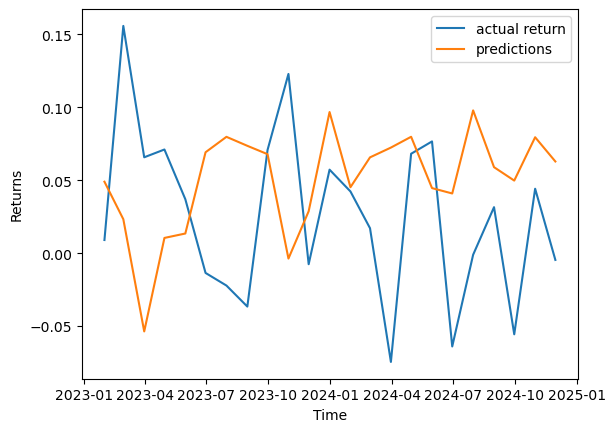

In [246]:
df, X_train, X_test, y_train, y_test = test_train_split('MSFT')

lstm(X_train, X_test, y_train, y_test)

In [247]:
df

,MSFT_RETURN,MSFT_STDEV,MSFT_ROLL_AVG,SP500_RETURN,SP500_STDEV,RF,Inflation Rate,Next_MSFT_RETURN
Date,,,,,,,,
2015-06-30,-0.057832,0.009569,-0.002530,-0.021012,0.007012,0.0000,0.002768,0.057757
2015-07-31,0.057757,0.012318,0.000054,0.019742,0.007372,0.0000,0.001586,-0.061948
2015-08-31,-0.061948,0.023279,-0.002064,-0.062581,0.016831,0.0000,-0.000004,0.017003
2015-09-30,0.017003,0.017814,-0.001926,-0.026443,0.014185,0.0000,-0.002248,0.189336
2015-10-31,0.189336,0.023702,0.006596,0.082983,0.007941,0.0000,0.000989,0.039444
...,...,...,...,...,...,...,...,...
2024-07-31,-0.063989,0.014703,-0.002225,0.011321,0.009106,0.0045,0.001389,-0.001095
2024-08-31,-0.001095,0.012256,-0.001402,0.022835,0.012262,0.0048,0.001802,0.031548
2024-09-30,0.031548,0.011563,0.000986,0.020197,0.008719,0.0040,0.002292,-0.055659


In [248]:
# preds = {}

# for stock in stock_list: 
#     next_month_pred = lstm_pred(stock)

#     preds[stock] = next_month_pred

# preds


In [249]:
# aapl = pd.concat([result.filter(like = 'AAPL'),result[['SP500_RETURN','SP500_STDEV', 'RF', 'Inflation Rate']]], axis=1)

# # # Including past historical distorts the result 
# # aapl = aapl.loc[(aapl.index.year >= 2022)]

# # To ensure that it is sequentially ordered 
# aapl.sort_index(inplace=True)

# # shift target variable 
# aapl["Next_AAPL_RETURN"] = aapl["AAPL_RETURN"].shift(-1)
# # NaN in last row because of the shift 
# aapl.dropna(inplace=True)


In [233]:
# # Defining target and features 
# features = [col for col in aapl.columns if col not in ["Next_AAPL_RETURN"]]
# target = "Next_AAPL_RETURN"

# X = aapl[features]
# y = aapl[target]

# # Normalize and split the data 
# # scaler = StandardScaler()
# scaler = MinMaxScaler() 

# train_size = int(len(X) * 0.8)
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # reshaping because lstm needs 3d input 
# X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
# X_test = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [234]:
# X_train

In [235]:
# model = Sequential([
#     LSTM(50, return_sequences=True, input_shape=(1, X_train.shape[2])),
#     LSTM(50),
#     Dense(25, activation='relu'),
#     Dense(1)
# ])

# model.compile(optimizer="adam", loss="mse")

# model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))
 



In [236]:
# start = dt.datetime(2000, 1, 1)
# end = dt.datetime(2025, 2,2)

# returns = yf.download(stock_list, start-pd.offsets.BDay(1), end+pd.offsets.BDay(1), auto_adjust=False)['Adj Close'].pct_change().dropna()
# check_returns_mon = returns.resample(rule = 'ME').apply(lambda x: x.add(1).prod().sub(1))

# check_returns_mon

In [237]:
# next_month_pred = model.predict(X_test[-1].reshape(1, 1, X_test.shape[2]))
# print("Predicted AAPL Return for Next Month:", next_month_pred[0][0])

# y_pred = model.predict(X_test)
# y_test_copy = y_test.values.reshape(-1,1)

# Y = np.hstack((y_pred, y_test_copy))
# print('Side by side comparison y_pred vs y') 
# print(Y)

In [238]:
# plt.plot(y_test, label = "actual return")
# plt.plot(pd.Series(y_pred.flatten(), index=y_test.index), label = "predictions")
# plt.legend() 
# plt.xlabel('Time')
# plt.ylabel('Returns')
# plt.show()